Задание 1:
    Для указанных в варианте двух функций найти точку локального минимума, пользуясь указанными методами.
Если локальных минимумов несколько, достаточно найти только один из них. Для контроля правильности реализации
методов, используйте встроенные функции из библиотеки scipy (результат этого контроля привести в отчете).
    Сравнить методы, сделать вывод.
    Построить графики минимизируемых функций в виде поверхности таким образом, чтобы был виден искомый локальный
минимум. Для каждого из методов нанести точками на контурный график функции последовательность приближений.

Функции, которые необходимо минимизировать:

$$f(x,y)=(x-3)^3+(y-2)^2+(x-y-4)^2$$
$$f(x_1, x_2)=\sum_{k=1}^{10} ((e^{-0.1kx_1}-e^{-0.1kx_2})-(e^{-0.1k}-e^{-k}))^2$$

Решение проблемы минимума для первой функции:
Метод Нелдера-Мида: значение - 3.0000011411226684,	точка - [3.99922061 0.99927122]
Метод Флетчера-Ривса: значение - 3.0000000000000657,	точка - [4.00000012 0.99999992]
Встроенный метод: значение - 3.0,	точка - [4. 1.]

Последовательность приближений метода Нелдера-Мида для первой функции


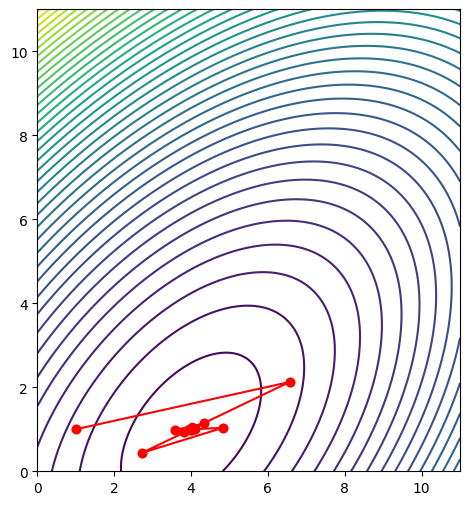

Последовательность приближений метода Флетчера-Ривса для первой функции


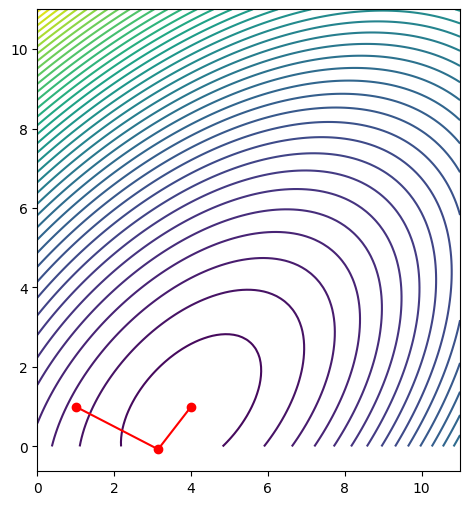


Решение проблемы минимума для второй функции:
Метод Нелдера-Мида: значение - 1.37362914178874e-06,	точка - [ 1.00132574 10.00809423]
Метод Флетчера-Ривса: значение - 1.1322702963143777e-10,	точка - [ 1.00000389 10.00023098]
Встроенный метод: значение - 5.230523341611803e-09,	точка - [1.         9.99851671]

Последовательность приближений метода Нелдера-Мида для второй функции


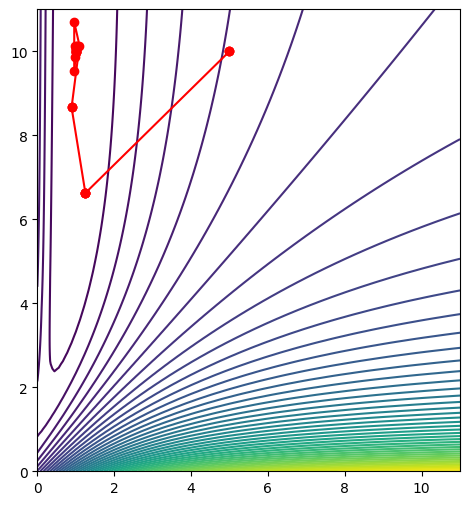

Последовательность приближений метода Флетчера-Ривса для второй функции


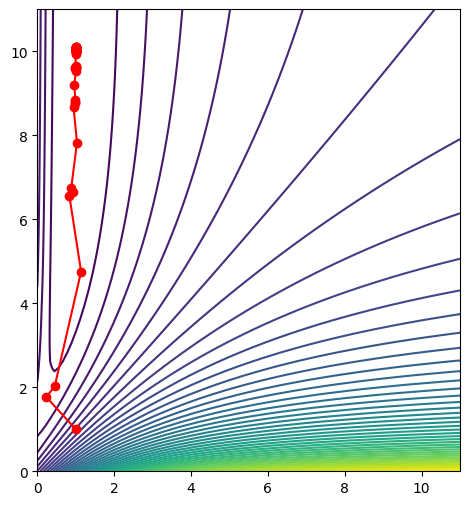

In [3]:
import numpy as np
from math import sqrt
from numpy.linalg import norm
import matplotlib.pyplot as plt
from scipy.optimize import minimize


def f1(x):
    return (x[0] - 3)**2 + (x[1] - 2)**2 + (x[0] - x[1] - 4)**2

def f2(x):
    sum = 0.
    for k in range(1, 11):
        sum += (((np.exp(-0.1 * k * x[0]) - np.exp(-0.1 * k * x[1])) - (np.exp(-0.1 * k) - np.exp(-k)))**2)
    return sum

# X_e
def extension(x1, x2, gamma = 2):
    return (1 - gamma) * x1 + gamma * x2

# X_r
def reflection(x1, x2, alpha = 1):
    return (1 + alpha) * x1 - alpha * x2

# X_s
def squeezing(x1, x2, beta = 0.5):
    return (1 - beta) * x1 + beta * x2

def reduction(x1, x2):
    return (x1 + x2) * 0.5

def my_sort(x, f):
    Fs = [(f(i), i) for i in x]
    Fs = sorted(Fs, reverse=1)
    return Fs

def conditionForNelderMead(f1, f2, f3, eps = 1e-4):
    avgF = (f1 + f2 + f3) / 3
    standardDeviation = sqrt(((f1 - avgF)**2 + (f2 - avgF)**2 + (f3 - avgF)**2) / 2)
    return standardDeviation <= eps

def nelder_mead(f):
    xh, xg, xl = np.array([5, 10]), np.array([10, 1]), np.array([1, 1])
    eps = 1e-6
    sequence = []

    while True:
        x = [xh, xg, xl]
        (fh, xh), (fg, xg), (fl, xl) = my_sort(x, f)
        sequence.append(xl)

        if conditionForNelderMead(fh, fg, fl, eps):
            print(f"Метод Нелдера-Мида: значение - {fl},\tточка - {xl}")
            break

        xc = reduction(xg, xl)

        xr = reflection(xc, xh)
        fr = f(xr)

        if fl > fr:
            xe = extension(xc, xr)
            fe = f(xe)
            if fe < fr:
                xh, fh = xe, fe
            else:
                xh, fh = xr, fr
            continue
        elif fg > fr and fr > fl:
            xh, fh = xr, fr
            continue
        elif fh > fr and fr > fg:
            xh, xr = xr, xh
            fh, fr = fr, fh

        xs = squeezing(xc, xh)
        fs = f(xs)
        if fs < fh:
            xh, fh = xs, fs
        else:
            xh, xg = reduction(xh, xl), reduction(xg, xl)
    return sequence


def gradF1(x):
    return np.array([4 * x[0] - 2 * x[1] - 14, 4 * x[1] - 2 * x[0] + 4])

def gradF2(x):
    sums = np.array([0., 0.])
    for k in range(1, 11):
        sums += np.array([-0.2 * k * (np.exp(-0.2*k*x[0]) - np.exp(-0.1*k*(x[0]+x[1])) - np.exp(-0.1*k*(x[0] + 1)) + np.exp(-k*(0.1*x[0]+1))),
                          0.2 * k * (np.exp(-0.1*k*(x[0]+x[1])) - np.exp(-0.2*k*x[1]) - np.exp(-0.1*k*(x[1] + 1)) + np.exp(-k*(0.1*x[1]+1)))])
    return sums

def conditionForFletcherReeves(x1, gradF, eps = 1e-4):
    grad = gradF(x1)
    return sqrt(grad[0]**2 + grad[1]**2) < eps

def fletcher_reeves(f, gradF):
    eps = 1e-6
    x_0 = np.array([1, 1])
    s_0 = -gradF(x_0)
    sequence = [x_0]

    while True:
        xFun = lambda l: f(x_0 + l * s_0)
        l = float(minimize(xFun, 1).x[0])
        x_1 = x_0 + l * s_0
        sequence.append(x_1)

        if conditionForFletcherReeves(x_1, gradF, eps):
            print(f"Метод Флетчера-Ривса: значение - {f(x_1)},\tточка - {x_1}")
            break

        omega = (norm(gradF(x_1))**2) / (norm(gradF(x_0))**2)
        x_0 = x_1
        s_0 = -gradF(x_1) + omega * s_0
    return sequence

def built_in(f):
    cons = ({'type': 'ineq', 'fun': lambda x:  x[0] - 1},
        {'type': 'ineq', 'fun': lambda x:  x[1] - 1},
        {'type': 'ineq', 'fun': lambda x:  10 - x[0]},
        {'type': 'ineq', 'fun': lambda x:  10 - x[1]})

    res = minimize(f, [1, 1], constraints=cons)
    print(f"Встроенный метод: значение - {res.fun},\tточка - {res.x}")

def plot_contour(f, sequence):
    x = np.linspace(0, 11, 100)
    y = np.linspace(0, 11, 100)
    X, Y = np.meshgrid(x, y)
    Z = f([X, Y])
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.contour(X, Y, Z, levels=50)
    plt.plot(*zip(*sequence), 'ro-')
    plt.show()

def main():
    print("Решение проблемы минимума для первой функции:")
    sequence1 = nelder_mead(f1)
    sequence2 = fletcher_reeves(f1, gradF1)
    built_in(f1)
    print("\nПоследовательность приближений метода Нелдера-Мида для первой функции")
    plot_contour(f1, sequence1)
    print("Последовательность приближений метода Флетчера-Ривса для первой функции")
    plot_contour(f1, sequence2)
    print("\nРешение проблемы минимума для второй функции:")
    sequence1 = nelder_mead(f2)
    sequence2 = fletcher_reeves(f2, gradF2)
    built_in(f2)
    print("\nПоследовательность приближений метода Нелдера-Мида для второй функции")
    plot_contour(f2, sequence1)
    print("Последовательность приближений метода Флетчера-Ривса для второй функции")
    plot_contour(f2, sequence2)

if __name__ == "__main__":
    main()